In [1]:
from seirsplus.models import *
from seirsplus.networks import *
import networkx as nx
import numpy as np
import random

In [2]:
##initialize parameters
SIGMA  = 1/5.2
GAMMA  = 1/10
MU_I   = 0.002

R0     = 2.5
BETA   = 1/(1/GAMMA) * R0
BETA_Q = 0.5*BETA

P      = 0.2
Q      = 0.05

In [3]:
class MyModel():
#     0 for S
#     1 for E
#     2 for I
#     3 for R
#     4 for F
#     5 for Q_E
#     6 for Q_I
    def __init__(self, G, beta, sigma, gamma, alpha = 1.0,
                    mu_I=0,  f=0, p=0, 
                     beta_Q=None, sigma_Q=None, gamma_Q=None,
                     initI=0, theta_E=0.2, theta_I=0.2):
        
        self.G = G
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.alpha = alpha
        self.mu_I = mu_I
        self.f = f
        self.p = p
        self.beta_Q = beta_Q
        self.sigma_Q = sigma_Q
        self.gamma_Q = gamma_Q
        self.initI = initI
        self.theta_E = theta_E
        self.theta_I = theta_I
        
        Icount = initI
        Ecount = 1
        Scount = 0
        Dict = {}
        Ncount = 0
        for node in G.nodes:
            s = random.random()
            if s<(initI/len(G.nodes())+0.01) and Icount>0:
                state = 2
                Icount -= 1
            elif s>0.99 and Ecount>0:
                state = 1
                Ecount = 0
            else:
                Scount += 1
                state = 0
            Dict[Ncount] = {}
            Dict[Ncount]['state'] = state
            Ncount += 1
        
        nx.set_node_attributes(G, Dict)
        
        self.numS = []
        self.numE = []
        self.numI = []
        self.numR = []
        self.numF = []
        self.numQ_E = []
        self.numQ_I = []
        self.tseries = []
        
        self.numS.append(Scount)
        self.numE.append(1)
        self.numI.append(initI-Icount)
        self.numR.append(0)
        self.numF.append(0)
        self.numQ_E.append(0)
        self.numQ_I.append(0)
        
        self.numS1 = [Scount]
        self.numE1 = [1]
        self.numI1 = [initI-Icount]
        self.numR1 = [0]
        self.numF1 = [0]
        self.numQ_E1 = [0]
        self.numQ_I1 = [0]
        self.tseries.append(0)
        
        
        print("S=", self.numS[0])
        print("E=", self.numE[0])
        print("I=", self.numI[0])
        print("R=", self.numR[0])
        print("F=", self.numF[0])
        print("Q_E=", self.numQ_E[0])
        print("Q_I=", self.numQ_I[0])
        
        
    def run(self, T):
        period = 1
        self.numS.append(self.numS[period-1])
        self.numE.append(self.numE[period-1])
        self.numI.append(self.numI[period-1])
        self.numR.append(self.numR[period-1])
        self.numF.append(self.numF[period-1])
        self.numQ_E.append(self.numQ_E[period-1])
        self.numQ_I.append(self.numQ_I[period-1])
        TPassed = 0
        infect = [0] * len(self.G.nodes)
        infectQ = [0] * len(self.G.nodes)
        testE = [0] * len(self.G.nodes)
        testI = [0] * len(self.G.nodes)
        recover = [0] * len(self.G.nodes)
        recoverQ = [0] * len(self.G.nodes)
        deathQ = [0] * len(self.G.nodes)
        while T > 0:
            states = nx.get_node_attributes(self.G, 'state')
            Dict = {}
            remove = []
            Nidx = 0
            for node in list(self.G.nodes):
                newstate = -1
                deceased = False
                if states[node] == 0:
                    rand = random.random()
                    infcount = 0
                    for adj in self.G.neighbors(node):
                        if states[adj] == 2:
                            infcount+=1
                    propen = self.alpha*(self.p*((self.beta*self.numI[period-1]+self.beta_Q*self.numQ_I[period-1])/len(self.G.nodes))+(1-self.p)*(infcount/max(1,self.G.degree(node))))
                    if rand<=propen:
                        newstate = 1
                        self.numS[period]-=1
                        self.numE[period]+=1
                    if newstate == -1:
                        newstate = 0
                ###########################################
                elif states[node] == 1:
                    test = testE[Nidx]
                    inf = infect[Nidx]
                    if test>=1 and test>=inf:
                        newstate = 5 
                        self.numE[period] -= 1
                        self.numQ_E[period] += 1
                    if inf>=1 and inf>test:
                        newstate = 2  #infected
                        self.numE[period]-=1
                        self.numI[period]+=1
                    if newstate == -1:
                        testE[Nidx]+=self.theta_E
                        infect[Nidx]+=self.sigma
                        newstate = 1
                ###########################################
                elif states[node] == 2:
                    death = random.random()
                    if death<self.f:
                        newstate = 4
                        self.numI[period]-=1
                        self.numF[period]+=1
                        deceased = True
                        self.G.remove_node(node) #deceased
                        remove.append(Nidx)
                    else:
                        rec = recover[Nidx]
                        test = testI[Nidx]
                        if rec>=1 and rec>=test:
                            newstate = 3 #recovered
                            self.numI[period]-=1
                            self.numR[period]+=1
                        if test>=1 and test>rec:
                            newstate = 6 
                            self.numI[period]-=1
                            self.numQ_I[period]+=1     
                    if newstate == -1:
                        recover[Nidx]+=self.gamma
                        testI[Nidx]+=self.theta_I
                        newstate = 2
                elif states[node] == 3:
                    newstate = 3
                elif states[node] == 4:
                    newstate = 4
                    ###########################################
                elif states[node] == 5:
                    if infectQ[Nidx]>=1:
                        newstate = 6  #q_i
                        self.numQ_E[period]-=1
                        self.numQ_I[period]+=1
                    else:
                        infectQ[Nidx]+=self.sigma_Q
                        newstate = 5
                    ###########################################
                elif states[node] == 6:
                    death = deathQ[Nidx]
                    recQ = recoverQ[Nidx]
                    if death>=1 and death>= recQ:
                        self.numQ_I[period]-=1
                        self.numF[period]+=1
                        newstate = 4
                        deceased = True
                        remove.append(Nidx)
                        self.G.remove_node(node)
                    if recQ>=1 and recQ>death:
                        newstate = 3 #recovered
                        self.numQ_I[period]-=1
                        self.numR[period]+=1
                    if newstate == -1:
                        deathQ[Nidx]+=self.mu_I
                        recoverQ[Nidx]+=self.gamma_Q
                        newstate = 6
                    ###########################################
                if not deceased:
                    Dict[node] = {}
                    Dict[node]['state'] = newstate
                Nidx+=1
                
            for idx in remove:
                del infect[idx]
                del infectQ[idx]
                del testE[idx]
                del testI[idx]
                del recover[idx]
                del recoverQ[idx]
                del deathQ[idx]

            nx.set_node_attributes(self.G, Dict)
            T -= 1
            TPassed += 1
            
            self.numS1.append(self.numS[period])
            self.numE1.append(self.numE[period])
            self.numI1.append(self.numI[period])
            self.numR1.append(self.numR[period])
            self.numF1.append(self.numF[period])
            self.numQ_E1.append(self.numQ_E[period])
            self.numQ_I1.append(self.numQ_I[period])
            
            self.tseries.append(100-T)
            
            if TPassed == 10:
                period+=1
                self.numS.append(self.numS[period-1])
                self.numE.append(self.numE[period-1])
                self.numI.append(self.numI[period-1])
                self.numR.append(self.numR[period-1])
                self.numF.append(self.numF[period-1])
                self.numQ_E.append(self.numQ_E[period-1])
                self.numQ_I.append(self.numQ_I[period-1])
                TPassed = 0
                
                print("#############################", "period", period-1, ": ")
                print("S=", self.numS[period-1])
                print("E=", self.numE[period-1])
                print("I=", self.numI[period-1])
                print("R=", self.numR[period-1])
                print("F=", self.numF[period-1])
                print("Q_E=", self.numQ_E[period-1])
                print("Q_I=", self.numQ_I[period-1])
                print("N=", len(self.G.nodes))

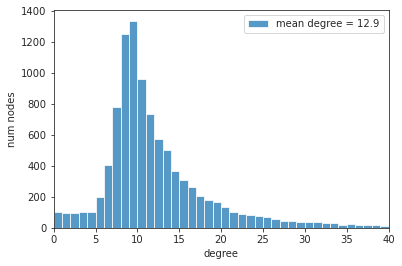

In [4]:
numNodes = 10000
baseGraph = nx.barabasi_albert_graph(n=numNodes, m=9)
# Baseline normal interactions:
G_normal = custom_exponential_graph(baseGraph, scale=100)
plot_degree_distn(G_normal, max_degree=40)

In [5]:
model = MyModel(G       = G_normal, 
                beta    = BETA,   #0.25
                sigma   = SIGMA,  #0.18
                gamma   = GAMMA,  #0.1
                mu_I    = MU_I,  #0.002
                f       = 0.04,
                p       = P,    #0.2
                beta_Q  = BETA_Q, #0.125
                sigma_Q = SIGMA, #0.18
                gamma_Q = GAMMA,  #0.1
                initI   = numNodes/100, #100
                theta_E = 0.5, 
                theta_I = 0.5)

S= 9899
E= 1
I= 100.0
R= 0
F= 0
Q_E= 0
Q_I= 0


In [6]:
model.run(T=100)

############################# period 1 : 
S= 9597
E= 17
I= 0.0
R= 0
F= 14
Q_E= 285
Q_I= 87
N= 9986
############################# period 2 : 
S= 9572
E= 7
I= 0.0
R= 86
F= 14
Q_E= 18
Q_I= 303
N= 9986
############################# period 3 : 
S= 9501
E= 20
I= 0.0
R= 375
F= 14
Q_E= 51
Q_I= 39
N= 9986
############################# period 4 : 
S= 9493
E= 1
I= 0.0
R= 410
F= 14
Q_E= 7
Q_I= 75
N= 9986
############################# period 5 : 
S= 9474
E= 4
I= 0.0
R= 472
F= 14
Q_E= 15
Q_I= 21
N= 9986
############################# period 6 : 
S= 9470
E= 1
I= 0.0
R= 492
F= 14
Q_E= 3
Q_I= 20
N= 9986
############################# period 7 : 
S= 9466
E= 2
I= 0.0
R= 510
F= 14
Q_E= 2
Q_I= 6
N= 9986
############################# period 8 : 
S= 9463
E= 0
I= 0.0
R= 515
F= 14
Q_E= 3
Q_I= 5
N= 9986
############################# period 9 : 
S= 9463
E= 0
I= 0.0
R= 519
F= 14
Q_E= 0
Q_I= 4
N= 9986
############################# period 10 : 
S= 9460
E= 0
I= 0.0
R= 523
F= 14
Q_E= 3
Q_I= 0
N= 9986


In [24]:
model_1 = SEIRSModel(initN = 10000,
                    beta    = BETA, 
                    sigma   = SIGMA, 
                    gamma   = GAMMA, 
                    mu_I    = MU_I,
                    p       = P,    
                    beta_Q  = BETA_Q, 
                    sigma_Q = SIGMA, 
                    gamma_Q = GAMMA, 
                    theta_E = 0.5, 
                    theta_I = 0.5,
                    psi_E   = 1.0, 
                    psi_I   = 1.0,
                    initI   = 100)

In [25]:
model_1.run(T=100, verbose = True)

t = 99.90
	 S   = 9853.707202838881
	 E   = -2.451324854968405e-07
	 I   = 1.762449463723724e-07
	 Q_E = 5.388539253436661e-07
	 Q_I = 0.00845961849077571
	 R   = 143.4160167378982
	 F   = 2.8683203347579647


True

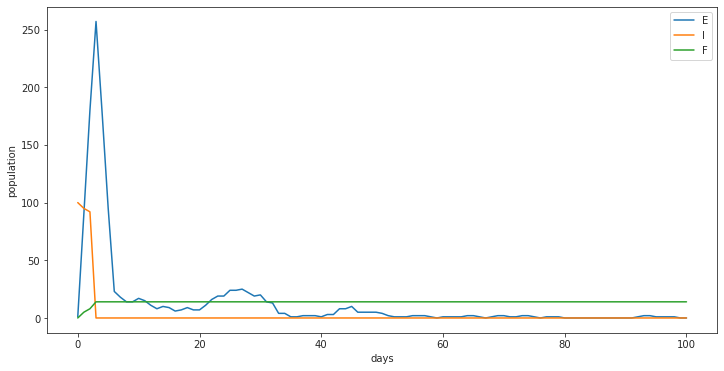

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("days")
plt.ylabel("population")
e, = plt.plot(model.tseries, model.numE1)
i, = plt.plot(model.tseries, model.numI1)
f, = plt.plot(model.tseries, model.numF1)
ll = plt.legend([e,i,f], ["E", "I", "F"],loc='upper right')

/home/y5ren/.local/lib/python3.8/site-packages/seirsplus/models.py:430: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


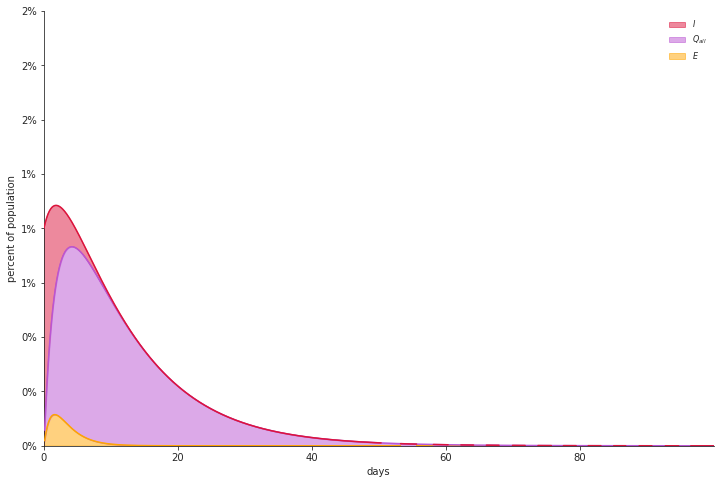

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='days', ylabel='percent of population'>)

In [13]:
model_1.figure_infections(ylim=0.02)